## 0. Import packages

In [1]:
# model imports

import numpy as np

import utils
from het_block import het
import simple_block as sim
from simple_block import simple
from consav.markov import log_rouwenhorst
import jacobian as jac
import nonlinear
import HANK_durables as hank
import determinacy as det
from scipy import optimize
import Monte_Carlo

# DAG imports
import networkx as nx
import matplotlib.pyplot as plt
import pylab
import pandas as pd

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

<a id="2-calibration"></a>

## 1. Calibrating the steady state


In [2]:
household = hank.household

In [3]:
def hank_ss(Bg_Y=0.26,beta_guess=0.9745, r=0.03/4, kappa=0.038846, sigma_N=1.0, sigma_D=1.0, delta=0.1, alpha = 12.0, vareps=10.0, tau_e = 0,  rho_e=0.9777, sigma_e=0.1928,
            phi_pi=1.5, phi_y = 0.125, theta = 1.001, xi = 105, Ne=7, Nb=80, Nd=90,  bmax=150, dmax=135):
    """Solve steady state of full GE model. Calibrate beta to hit target interest rate where parameters adjust to get N=1, Y=1, Q=1"""

    # a. set up grids
    psi = 0.5 # "bmin":: psi*Y, Y=1
    b_grid = utils.agrid(amax=bmax, n=Nb, amin=-psi)
    d_grid = utils.agrid(amax=dmax, n=Nd, amin=1e-6)
    e_grid, Pi_e, e_ergodic, _, _ = log_rouwenhorst(rho_e,sigma_e,Ne)
    #e_grid, e_ergodic, Pi_e = utils.markov_rouwenhorst(rho=rho_e, sigma=sigma_e, N=Ne)
    Nk = Nd # number of grid points for lagrange multiplier grid
    kmax = 1.0 # 1 = max for lagrange mult.
    k_grid = utils.agrid(amax=kmax,n=Nk,amin=0)
     
    # b. solve analytically what we can (zero inflation s.s.)
    N = 1 # as psi_N = W/P_n * 1/C, psi_N found after root finding
    Q = 1.0 # as chi = C / (C+D), chi found after root finding
    A = 1.0/N # s.s. TFP level, set such that Y = 1
    markup_p_ss = vareps/(vareps-1) # P mark-up
    P = 1.0 # numeriare
    W = (A*P)/markup_p_ss
    Y = A*N # Y = 1
    P_n = P # price of non-durables, follows from retailer price relation
    P_d = P # price of durables, follows from retailer price relation
    Div = Y - N*(W/P) # s.s. profits
    Bg = Bg_Y*Y
    Tax = r*Bg
    
    #B_y moms['B_demand'] / (4*moms['Y'])

    # c. initialize guess for policy function iteration
    c = (b_grid[:, np.newaxis] + d_grid)/2
    c[c<0] = 1e-8 # assert c>0
    d = c
    Vb = c**(-1/sigma_N) * np.ones((e_grid.shape[0], 1, 1))
    Vd = d**(-1/sigma_N) * np.ones((e_grid.shape[0], 1, 1))
    Vd[:] = 0.

    # e. define residual function
    def residual(x0):

        # a. solve household ss problem
        out = household.ss(Vd=Vd, Vb=Vb, Pi_e=Pi_e, b_grid=b_grid, dg_grid=d_grid, k_grid=k_grid, e_grid=e_grid, e_ergodic=e_ergodic, sigma_N=sigma_N, sigma_D=sigma_D,
                                 alpha=alpha,delta=delta,r=r,kappa=kappa,Div=Div,beta=x0,Ne=Ne,Nb=Nb,Nd=Nd,Nk=Nk,P=P,P_d=P_d,P_n=P_n,W=W,N=N,tau_e=tau_e,Tax=Tax)
        
        print(x0,[out['B'] - Bg],out['DG'],out['C'])
                                 
        return np.array([out['B'] - Bg]) 

    # f. solve for beta given asset market clearing
    # i. call optimizer
    result = optimize.root_scalar(residual,bracket=[1/(1+r)-0.05,1/(1+r)-0.01],method='bisect',rtol=1e-6) # cannot go higher than 1/(1+r)
    # ii. save result
    beta = result.root
    

    # g. extra evaluation for reporting
    ss = household.ss(Vd=Vd, Vb=Vb, Pi_e=Pi_e, b_grid=b_grid, dg_grid=d_grid, k_grid=k_grid, e_grid=e_grid, e_ergodic=e_ergodic, sigma_N=sigma_N, sigma_D=sigma_D,
                                 alpha=alpha,delta=delta,r=r,kappa=kappa,Div=Div,beta=beta,Ne=Ne,Nb=Nb,Nd=Nd,Nk=Nk,P=P,P_d=P_d,P_n=P_n,W=W,N=N,tau_e=tau_e,Tax=Tax)
    
    # h. update parameters that take adjustment for hitting targets in wage schedule and combined retailer FOC equations
    psi_N = (W/P) * (1/(ss['C']**sigma_N))
    chi = ss['C']/(ss['C']+ss['C_D'])
        
    # h. add aggregate variables
    ss.update({'phi_pi': phi_pi, 'phi_y': phi_y, 'Y': Y, 'Y_ss': Y, 'rstar': r, 'markup_p_ss': markup_p_ss, 'markup_p': markup_p_ss, 'A': A, 'Bg': Bg, 'N': N, 'P': P, 'Pi': P/P, 'W': W,
               'chi': chi, 'psi_N': psi_N, 'kappa': kappa, 'dg_grid': d_grid, 'Q': Q, 'P_d': P_d, 'P_n': P_n, 'Div': Div, 'vareps': vareps, 'phi_pi': phi_pi, 'phi_y': phi_y,
               'theta': theta, 'xi': xi, 'sigma_N': sigma_N, 'sigma_D': sigma_D, 'e_ergodic': e_ergodic,'ssflag': False}) # P_d=P_n=P+eps for numerical stability
    return ss

In [4]:
ss = hank_ss()
ss['beta']

0.9425558312655086 [-0.6747278077476988] 2.139253082677465 0.6205693547171837
0.9825558312655086 [6.039567381206536] 2.8982129212418903 0.5690827267859713
0.9625558312655086 [-0.21075192635829668] 2.4249544082799606 0.5862500806517316
0.9725558312655086 [0.9116405624424568] 2.6111976429183787 0.5706680522033808
0.9675558312655086 [0.17490714923761047] 2.5120548240009213 0.5779732680187096
0.9650558312655086 [-0.051905897712725774] 2.4670287914827123 0.5819592295202269
0.9663058312655086 [0.0513849783758496] 2.4891026204656117 0.579915137067046
0.9656808312655086 [-0.002477890457557641] 2.477974444463868 0.5809278169422522
0.9659933312655087 [0.023800970118525444] 2.4835061340683975 0.5804176692497285
0.9658370812655086 [0.010498770391966561] 2.480732225622017 0.5806717870458302
0.9657589562655087 [0.003972266611476594] 2.479351754607155 0.5807995986810159
0.9657198937655086 [0.0007402460635451691] 2.4786629546759764 0.5808637063717151
0.9657003625155086 [-0.0008680978868488287] 2.47831

0.9657107384920711

In [5]:
ss['DG']/ss['C']

4.26681412884314

In [6]:
b_grid = ss['b_grid']
b_neg_index = len(b_grid[b_grid<0]) - 1
bdmargdist = np.sum(ss['D'],axis=0) # sum out e
bmargdist = np.sum(bdmargdist,axis=1) # sum out d
np.sum(bmargdist[:b_neg_index])

0.31876763389866003

array([0.12537582, 0.01348181, 0.01128418, 0.01068453, 0.01083304,
       0.01134927, 0.0121566 , 0.01332323, 0.01484308, 0.01688964,
       0.01989622, 0.02454091, 0.0341093 ])

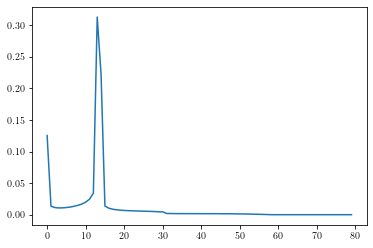

In [7]:
plt.plot(bmargdist[:])
bmargdist[:b_neg_index]

# 2. Steady-state distributions plots and tables

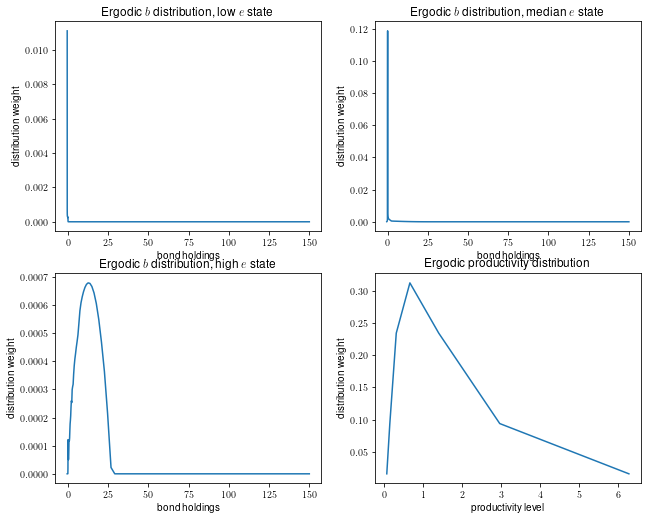

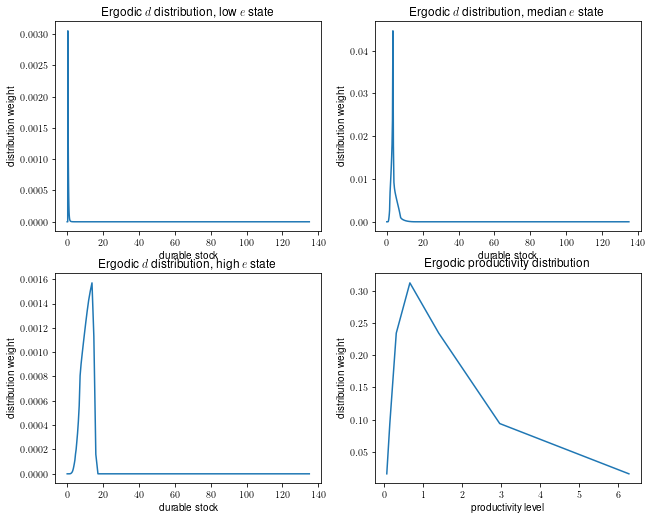

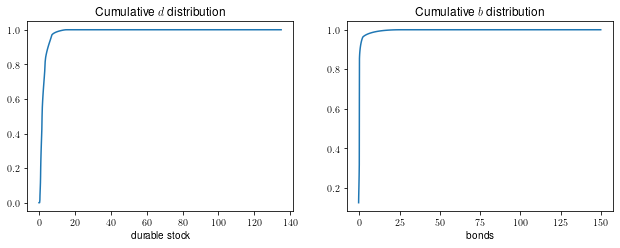

In [8]:
# a. marginal distributions
bdmargdist = np.sum(ss['D'],axis=0) # sum out e
dmargdist = np.sum(ss['D'],axis=1) # sum out b
dmargcum = np.cumsum(dmargdist)
bmargdist = np.sum(ss['D'],axis=2) # sum out d
bmargcum = np.cumsum(bmargdist)
e_ergodic = ss['e_ergodic']

# b. cumulative distributions
d_margdist = np.sum(bdmargdist,axis=0) # sum out b
dmargcum = np.cumsum(d_margdist)
b_margdist = np.sum(bdmargdist,axis=1) # sum out d
bmargcum = np.cumsum(b_margdist)

bmargcumfrac = np.cumsum(b_margdist*ss['b_grid']) 
bmargcumfrac /= bmargcumfrac[-1]

dmargcumfrac = np.cumsum(d_margdist*ss['dg_grid']) 
dmargcumfrac /= dmargcumfrac[-1]


# b. plots 
fig1 = plt.figure()
fig1.set_size_inches(10.5, 8.5)
ax1 = fig1.add_subplot(221)
ax1.plot(ss['b_grid'][:],bmargdist[0,:])
ax2 = fig1.add_subplot(222)
ax2.plot(ss['b_grid'][:],bmargdist[4,:])
ax3 = fig1.add_subplot(223)
ax3.plot(ss['b_grid'][:],bmargdist[-1,:])
ax4 = fig1.add_subplot(224)
ax4.plot(ss['e_grid'],ss['e_ergodic'])
ax1.title.set_text('Ergodic $b$ distribution, low $e$ state')
ax1.set_xlabel('bond holdings')
ax1.set_ylabel('distribution weight')
ax2.title.set_text('Ergodic $b$ distribution, median $e$ state')
ax2.set_xlabel('bond holdings')
ax2.set_ylabel('distribution weight')
ax3.title.set_text('Ergodic $b$ distribution, high $e$ state')
ax3.set_xlabel('bond holdings')
ax3.set_ylabel('distribution weight')
ax4.title.set_text('Ergodic productivity distribution')
ax4.set_xlabel('productivity level')
ax4.set_ylabel('distribution weight')
plt.show()
fig1.tight_layout(pad=7.0)
fig1.savefig("b_dists.pdf", bbox_inches='tight')

fig2 = plt.figure()
fig2.set_size_inches(10.5, 8.5)
ax1 = fig2.add_subplot(221)
ax1.plot(ss['dg_grid'][:100],dmargdist[0,:100])
ax2 = fig2.add_subplot(222)
ax2.plot(ss['dg_grid'][:100],dmargdist[4,:100])
ax3 = fig2.add_subplot(223)
ax3.plot(ss['dg_grid'][:100],dmargdist[-1,:100])
ax4 = fig2.add_subplot(224)
ax4.plot(ss['e_grid'],ss['e_ergodic'])
ax1.title.set_text('Ergodic $d$ distribution, low $e$ state')
ax1.set_xlabel('durable stock')
ax1.set_ylabel('distribution weight')
ax2.title.set_text('Ergodic $d$ distribution, median $e$ state')
ax2.set_xlabel('durable stock')
ax2.set_ylabel('distribution weight')
ax3.set_xlabel('durable stock')
ax3.set_ylabel('distribution weight')
ax3.title.set_text('Ergodic $d$ distribution, high $e$ state')
ax4.set_xlabel('durable stock')
ax4.set_ylabel('distribution weight')
ax4.title.set_text('Ergodic productivity distribution')
ax4.set_xlabel('productivity level')
ax4.set_ylabel('distribution weight')

plt.show()
fig2.tight_layout(pad=7.0)
fig2.savefig("d_dists.pdf", bbox_inches='tight')

fig3 = plt.figure()
fig3.set_size_inches(10.5, 3.5)
ax1 = fig3.add_subplot(121)
ax1.plot(ss['dg_grid'],dmargcum)
ax2 = fig3.add_subplot(122)
ax2.plot(ss['b_grid'],bmargcum)
ax1.title.set_text('Cumulative $d$ distribution')
ax1.set_xlabel('durable stock')
ax2.title.set_text('Cumulative $b$ distribution')
ax2.set_xlabel('bonds')

plt.show()
fig3.tight_layout(pad=4.0)
fig3.savefig("CDFs.pdf", bbox_inches='tight')

In [9]:
#simT = 3000
#simN = 90000
#b_policy = ss['b']
#d_policy = ss['dg']
#c_policy = ss['c']
#e_grid = ss['e_grid']
#d_grid = ss['dg_grid']
#b_grid = ss['b_grid']
#e_ergodic = ss['e_ergodic']
#Pi_e = ss['Pi_e']

#sim_b,sim_d,sim_c = Monte_Carlo.steady_state_MC(simT,simN,b_policy,d_policy,c_policy,e_grid,b_grid,d_grid,e_ergodic,Pi_e)

#sim_d_c = sim_d[1000:,:]/sim_c[1000:,:]
#skewness_d_c = 3*(np.mean(sim_d_c) - np.median(sim_d_c))/np.std(sim_d_c) #0.4627878092589748 #0.4930580812805126 # 0.5322452262264995
#print(f"Skewness D/C: {skewness_d_c:.3f}")

#x = sim_d_c
#hist, bins = np.histogram(x, bins=100)
#width = 0.7 * (bins[1] - bins[0])
#center = (bins[:-1] + bins[1:]) / 2
#plt.bar(center, hist, align='center', width=width)
#plt.xlabel('D/C')
#plt.ylabel('Count')
#plt.show()

In [10]:
# a. percentiles
moms = {}
pvec = [0.001,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.999]
for p in pvec:

    # durable
    if p <= dmargcum[0]:
        moms[('d',p)] = ss['dg_grid'][0]
    else:
        try:
            moms[('d',p)] = np.interp(p,dmargcum,ss['dg_grid'])
        except:
            moms[('d',p)] = np.nan

    # bonds
    if p <= bmargcum[0]:
        moms[('b',p)] = ss['b_grid'][0]
    else:
        try:
            moms[('b',p)] = np.interp(p,bmargcum,ss['b_grid'])
        except:
            moms[('b',p)] = np.nan
            
# b. table
print('d percentiles')
for p in reversed(pvec):
    print("%.3f" % p,"%.2f" % moms['d',p])
print('')
print('b percentiles')
for p in reversed(pvec):
    print("%.3f" % p,"%.2f" % moms['b',p])

d percentiles
0.999 14.20
0.990 10.48
0.950 6.57
0.900 5.03
0.750 3.09
0.500 1.69
0.250 1.03
0.100 0.73
0.050 0.56
0.010 0.42
0.001 0.31

b percentiles
0.999 20.08
0.990 10.02
0.950 1.53
0.900 0.40
0.750 -0.00
0.500 -0.06
0.250 -0.21
0.100 -0.50
0.050 -0.50
0.010 -0.50
0.001 -0.50


# 3. Linearized dynamics

## 3.1 Pre-requisite price relations from retailer FOC's

From the combined retailer F.O.C. we obtain $C_{d,t}(C_{d,t},Q_t)$
$$\left(\frac{\chi C_{d,t}}{(1-\chi)C_{t}}\right)^{\frac{1}{\theta}}=\frac{1}{Q_{t}}$$
$$\Rightarrow C_{d,t}=C_{t}Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)$$

Thus, we obtain $P_{n,t}$ from retailer FOC wrt. $C_t$
$$\begin{array}{c}
\Rightarrow P_{t}\left[(\chi)^{\frac{1}{\theta}}{C_{t}^{-\frac{1}{\theta}}}\left[(\chi)^{\frac{1}{\theta}}{\left(C_{t}\right)^{\frac{\theta-1}{\theta}}}+(1-\chi)^{\frac{1}{\theta}}\left({C_{t}}Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)\right)^{\frac{\theta-1}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[(\chi)^{\frac{1}{\theta}}\left[(\chi)^{\frac{1}{\theta}}+(1-\chi)^{\frac{1}{\theta}}\left(Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)\right)^{\frac{\theta-1}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}}\left[(\chi)^{\frac{1}{\theta}}+(1-\chi)^{\frac{1}{\theta}}\left(Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)\right)^{\frac{\theta-1}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[\left[(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}}(\chi)^{\frac{1}{\theta}}+(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}}(1-\chi)^{\frac{1}{\theta}}\left(Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)\right)^{\frac{\theta-1}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[\left[(\chi)^{\frac{1}{\theta}+\frac{1}{\theta}\frac{\theta-1}{1}}+(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}}(1-\chi)^{\frac{1}{\theta}}Q_{t}^{1-\theta}\left(1-\chi\right)^{\frac{\theta-1}{\theta}}\chi^{\frac{1-\theta}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[\left[(\chi)^{\frac{1}{\theta}+\frac{1}{\theta}\frac{\theta-1}{1}}+(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}+\frac{1-\theta}{\theta}}(1-\chi)^{\frac{1}{\theta}+\frac{\theta-1}{\theta}}Q_{t}^{1-\theta}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[\left[(\chi)^{1}+{(\chi)^{0}}(1-\chi)^{1}Q_{t}^{1-\theta}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow\frac{P_{t}}{P_{n,t}}=\left[\chi+(1-\chi)Q_{t}^{1-\theta}\right]^{\frac{1}{1-\theta}}
\end{array}$$

so $P_{n,t}=\left[\chi+(1-\chi)Q_{t}^{1-\theta}\right]^{\frac{1}{\theta-1}}P_{t}$

which pins downs $P_{d,t}$
$$P_{d,t}=P_{n,t}\cdot Q_t$$


## 3.1 Equilibrium equations neccessary to compute impulse responses

\begin{equation} P_{n,t}=\left[\chi+(1-\chi)Q_{t}^{1-\theta}\right]^{\frac{1}{\theta-1}}P_{t} \end{equation}

\begin{equation} P_{d,t}=P_{n,t}Q_t \end{equation}

\begin{equation} \Pi_{t}=\frac{P_{t}}{P_{t-1}} \end{equation}

\begin{equation} \mathcal{M}_{t}^{p}=\frac{1}{\frac{\xi}{\epsilon}\left(\Pi_{t}\left(\Pi_{t}-1\right)-\frac{1}{1+r_{t+1}}\left(\frac{Y_{t+1}}{Y_{t}}\right)\Pi_{t+1}\left(\Pi_{t+1}-1\right)\right)+\frac{1}{\mathcal{M}^{p}}} \end{equation}

\begin{equation} i_{t}=r_{t}^{*}+\phi_{\pi}\pi_{t}+\phi_{y} \hat{y}_t \end{equation}

\begin{equation} r_{t}=\frac{1+i_{t}}{1+\pi_{t}}-1 \end{equation}

\begin{equation} N_{t}=Y_{t}/A_{t} \end{equation}

\begin{equation} W_{t}=\frac{A_{t} P_{t}}{\mathcal{M}_{t}^{p} } \end{equation}

\begin{equation} Div_{t}=Y_{t}\left(1-(\xi/2)\left(\Pi_{t}-1\right)^{2}\right)-\frac{W_{t}}{P_{t}}N_{t} \end{equation}

\begin{equation} B_{t}=0 \end{equation}

\begin{equation} P_{n,t}C_{t}+P_{n,t}Q_tC_{d,t}-P_{t}Y_{t}=0 \end{equation}

\begin{equation} \frac{W_{t}}{P_{t}}=\psi_N N_{t}C_{n,t} \end{equation}

The endogenous variables are $U=(Y_{t},P_{t},Q_{t})$, the exogenous
variables are $Z=(r_{t}^{*},A_{t})$. With the following targets,
the system to be solved is given as

\begin{equation}
H\left(Y_{t},P_{t},Q_{t}\right)=\left(\begin{array}{c}
\text{Bonds market clearing}\\
\text{Retailer zero-profit condition}\\
\text{Wage schedule}
\end{array}\right)=\left(\begin{array}{c}
0\\
0\\
0
\end{array}\right)
\end{equation}

Denoting household solution variables as caligraphic variables for
$\mathcal{B},\mathcal{D},\mathcal{C}$, the system is explicitly

\begin{equation}
H\left(Y_{t},P_{t},Q_{t}\right)=\left(\begin{array}{c}
\mathcal{B}_{t}\\
P_{n,t}\mathcal{C}_{n,t} + P_{n,t}Q_t\mathcal{C}_{d,t} - P_t Y_t\\
\frac{W_{t}}{P_{t}}-\psi_{N}N_{t}\mathcal{C}_{n,t}
\end{array}\right)=\left(\begin{array}{c}
0\\
0\\
0
\end{array}\right)
\end{equation}


## Define simple blocks (eq. by eq.)

In [11]:
@simple
def prices(P,Q,chi,theta): # non-durable price from retailer FOC, durable price through Q definition
    P_n = P*(chi + (1-chi)*Q**(1-theta))**(1/(theta-1))
    P_d = Q*P_n
    return P_n,P_d

@simple
def inflation(P): # inflation definition
    Pi = P/P(-1) 
    return Pi

@simple
def markup_p(Pi,Y,xi,vareps,markup_p_ss,r): # P mark-up through Phillips curve
    markup_p = 1/((xi/vareps)*( Pi*(Pi-1) - (1/(1+r(+1))) * (Y(+1)/Y)*Pi(+1)*(Pi(+1) - 1) ) - 1/markup_p_ss)
    return markup_p

@simple
def taylor(rstar,Pi,Y,Y_ss,phi_pi,phi_y): # monetary policy
    i_minus = rstar + phi_pi*np.log(Pi) + phi_y*np.log(Y/Y_ss) # Taylor rule
    r = (1+i_minus)/(1+np.log(Pi)) - 1 # Fisher equation
    return r

@simple
def labor_supply(Y,A): # labor supply as a function of output and TFP
    N = Y/A
    return N

@simple
def wage(A,P,markup_p): # wage relation
    W = A*P/markup_p
    return W

@simple
def dividends(Y,W,N,P,Pi,xi): # firm profits
    Div = Y*(1-(xi/2)*(Pi-1)**2) - (W*N)/P
    return Div

@simple
def bond_market_clearing(B,Bg): # bond market clearing
    bond_mkt = B - Bg
    return bond_mkt

@simple
def zero_profit_retailer(P_d,C_D,C,P,P_n,Y,delta): # retailer zero-profit cond.
    retailer_res = P_n*C + P_d*C_D - P*Y
    return retailer_res

@simple
def DG_t(DG):
    DG_t = DG(-1)
    return DG_t

@simple
def wage_schedule(W,P,N,C,psi_N,sigma_N): # wage schedule target
    wage_res = W/P - psi_N*N*C**sigma_N
    return wage_res

@simple
def fiscal(r, Bg,W,P,N):
    Tax = r*Bg
    return Tax


### Cut to the chase
The surest way to obtain the general equilibrium Jacobians is to use the `get_G` convenience function. Notice the `save=True` option. This means that we're saving the HA Jacobians calculated along the way for later use.

In [12]:
# setup
T = 300
exogenous = ['rstar', 'A']
unknowns = ['Y','P','Q']
targets = ['bond_mkt','retailer_res','wage_res']

# general equilibrium jacobians
block_list = [prices,inflation,markup_p,taylor,labor_supply,wage,dividends,bond_market_clearing,zero_profit_retailer,wage_schedule,DG_t,fiscal,household] 
G = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)

# partial equilibrium jacobians (for decomposition)
curlyJs, required = jac.curlyJ_sorted(block_list, unknowns+exogenous, ss, T)

### Results

Now let's consider 20 basis point expansionary monetary policy shocks with different persistences and plot the response of endogenous variables.

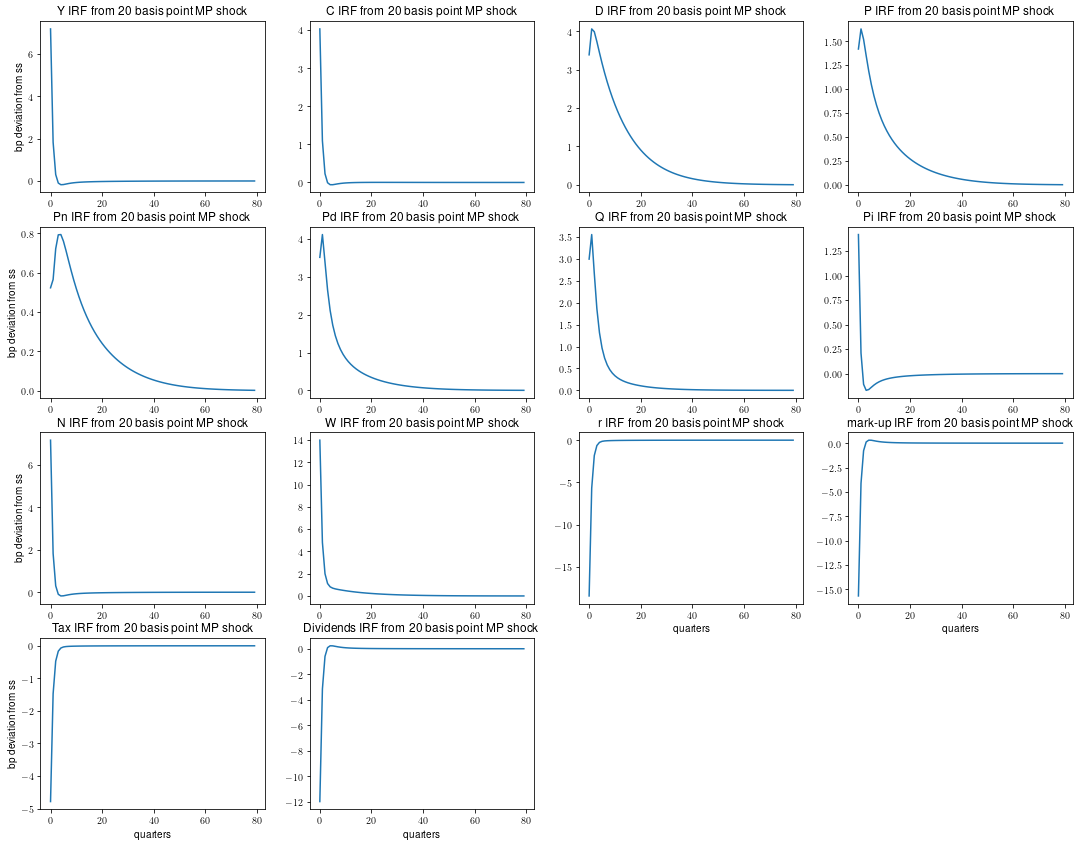

In [13]:
# a. collect impulses
rhos = np.array([0.3]) # persistence
drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])

dY = 10000*(G['Y']['rstar'] @ drstar)
dC = 10000*(G['C']['rstar'] @ drstar)
dD = 10000*(G['DG']['rstar'] @ drstar)
dP = 10000*(G['P']['rstar'] @ drstar)
dP_n = 10000*(G['P_n']['rstar'] @ drstar)
dP_d = 10000*(G['P_d']['rstar'] @ drstar)
dQ = 10000*(G['Q']['rstar'] @ drstar)
dPi = 10000*(G['Pi']['rstar'] @ drstar)
dN = 10000*(G['N']['rstar'] @ drstar)
dW = 10000*(G['W']['rstar'] @ drstar)
dr = 10000*(G['r']['rstar'] @ drstar)
dmarkup_p = 10000*(G['markup_p']['rstar'] @ drstar)
dTax = 10000*(G['Tax']['rstar'] @ drstar)
dDiv = 10000*(G['Div']['rstar'] @ drstar)
dB = 10000*(G['B']['rstar'] @ drstar)

# b. plots 
fig1 = plt.figure()
fig1.set_size_inches(18.5, 14.5)
ax1 = fig1.add_subplot(441)
ax1.plot(dY[:80])
ax2 = fig1.add_subplot(442)
ax2.plot(dC[:80])
ax3 = fig1.add_subplot(443)
ax3.plot(dD[:80])
ax4 = fig1.add_subplot(444)
ax4.plot(dP[:80])
ax5 = fig1.add_subplot(445)
ax5.plot(dP_n[:80])
ax6 = fig1.add_subplot(446)
ax6.plot(dP_d[:80])
ax7 = fig1.add_subplot(447)
ax7.plot(dQ[:80])
ax8 = fig1.add_subplot(448)
ax8.plot(dPi[:80])
ax9 = fig1.add_subplot(449)
ax9.plot(dN[:80])
ax10 = fig1.add_subplot(4,4,10)
ax10.plot(dW[:80])
ax11 = fig1.add_subplot(4,4,11)
ax11.plot(dr[:80])
ax12 = fig1.add_subplot(4,4,12)
ax12.plot(dmarkup_p[:80])
ax13 = fig1.add_subplot(4,4,13)
ax13.plot(dTax[:80])
ax14 = fig1.add_subplot(4,4,14)
ax14.plot(dDiv[:80])

ax1.title.set_text('Y IRF from 20 basis point MP shock')
ax2.title.set_text('C IRF from 20 basis point MP shock')
ax3.title.set_text('D IRF from 20 basis point MP shock')
ax4.title.set_text('P IRF from 20 basis point MP shock')
ax5.title.set_text('Pn IRF from 20 basis point MP shock')
ax6.title.set_text('Pd IRF from 20 basis point MP shock')
ax7.title.set_text('Q IRF from 20 basis point MP shock')
ax8.title.set_text('Pi IRF from 20 basis point MP shock')
ax9.title.set_text('N IRF from 20 basis point MP shock')
ax10.title.set_text('W IRF from 20 basis point MP shock')
ax11.title.set_text('r IRF from 20 basis point MP shock')
ax12.title.set_text('mark-up IRF from 20 basis point MP shock')
ax13.title.set_text('Tax IRF from 20 basis point MP shock')
ax14.title.set_text('Dividends IRF from 20 basis point MP shock')

ax1.set_ylabel('bp deviation from ss')
ax5.set_ylabel('bp deviation from ss')
ax9.set_ylabel('bp deviation from ss')
ax13.set_ylabel('bp deviation from ss')

ax11.set_xlabel('quarters')
ax12.set_xlabel('quarters')
ax13.set_xlabel('quarters')
ax14.set_xlabel('quarters')

plt.show()
fig1.tight_layout(pad=10.0)

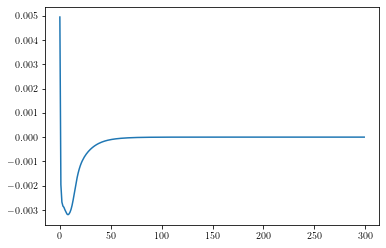

In [14]:
dC_K = 100*(G['C_K']['rstar'] @ drstar)
plt.plot(dC_K)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


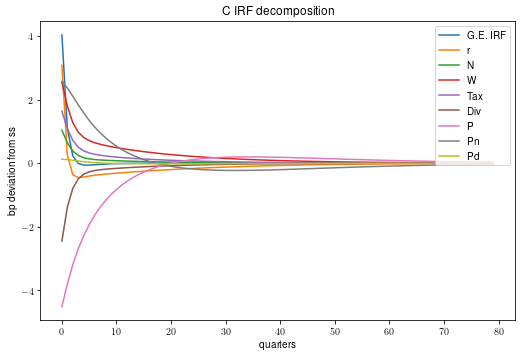

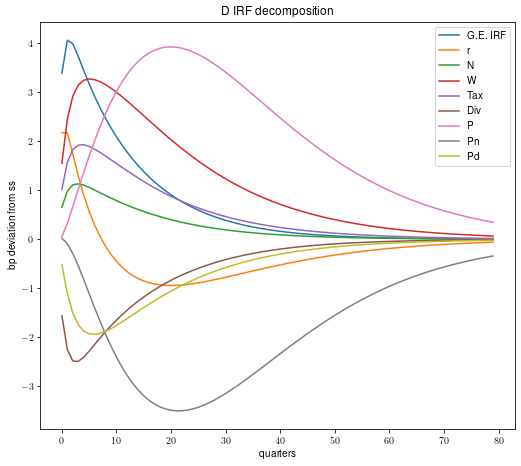

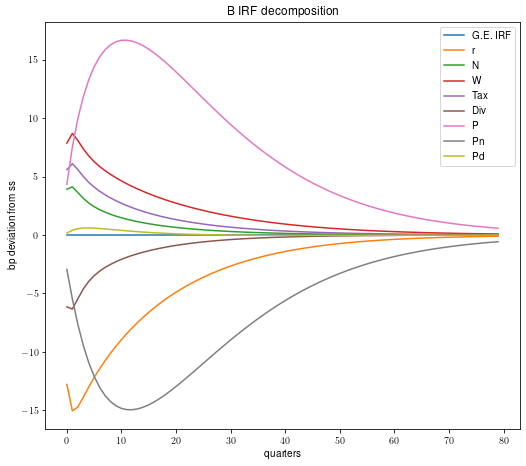

In [15]:
# a. collect P.E. IRFs for decomposition

dD_decomp = {}
dD_decomp['r'] = curlyJs[8]['DG']['r'] @ dr
dD_decomp['N'] = curlyJs[8]['DG']['N'] @ dN
dD_decomp['W'] = curlyJs[8]['DG']['W'] @ dW
dD_decomp['Tax'] = curlyJs[8]['DG']['Tax'] @ dTax
dD_decomp['Div'] = curlyJs[8]['DG']['Div'] @ dDiv
dD_decomp['P'] = curlyJs[8]['DG']['P'] @ dP
dD_decomp['Pn'] = curlyJs[8]['DG']['P_n'] @ dP_n
dD_decomp['Pd'] = curlyJs[8]['DG']['P_d'] @ dP_d

dC_decomp = {}
dC_decomp['r'] = curlyJs[8]['C']['r'] @ dr
dC_decomp['N'] = curlyJs[8]['C']['N'] @ dN
dC_decomp['W'] = curlyJs[8]['C']['W'] @ dW
dC_decomp['Tax'] = curlyJs[8]['C']['Tax'] @ dTax
dC_decomp['Div'] = curlyJs[8]['C']['Div'] @ dDiv
dC_decomp['P'] = curlyJs[8]['C']['P'] @ dP
dC_decomp['Pn'] = curlyJs[8]['C']['P_n'] @ dP_n
dC_decomp['Pd'] = curlyJs[8]['C']['P_d'] @ dP_d

dB_decomp = {}
dB_decomp['r'] = curlyJs[8]['B']['r'] @ dr
dB_decomp['N'] = curlyJs[8]['B']['N'] @ dN
dB_decomp['W'] = curlyJs[8]['B']['W'] @ dW
dB_decomp['Tax'] = curlyJs[8]['B']['Tax'] @ dTax
dB_decomp['Div'] = curlyJs[8]['B']['Div'] @ dDiv
dB_decomp['P'] = curlyJs[8]['B']['P'] @ dP
dB_decomp['Pn'] = curlyJs[8]['B']['P_n'] @ dP_n
dB_decomp['Pd'] = curlyJs[8]['B']['P_d'] @ dP_d

# b. plots
# i. non-durable consumption decomposition
fig2, ax15 = plt.subplots()
ax15.plot(dC[:80],label="G.E. IRF")
for key in dC_decomp:
    current_label = key
    ax15.plot(dC_decomp[key][:80],label=current_label)
ax15.legend(loc="upper right")
ax15.set_ylabel('bp deviation from ss')
ax15.set_xlabel('quarters')
ax15.title.set_text('C IRF decomposition')
fig2.set_size_inches(8.5, 5.5)


# ii. durable consumption decomposition
fig3, ax16 = plt.subplots()
ax16.plot(dD[:80],label="G.E. IRF")
for key in dD_decomp:
    current_label = key
    ax16.plot(dD_decomp[key][:80],label=current_label)
ax16.legend(loc="upper right")
ax16.set_ylabel('bp deviation from ss')
ax16.set_xlabel('quarters')
ax16.title.set_text('D IRF decomposition')
fig3.set_size_inches(8.5, 7.5)

# iii. savings decomposition
fig4, ax17 = plt.subplots()
ax17.plot(dB[:80],label="G.E. IRF")
for key in dB_decomp:
    current_label = key
    ax17.plot(dB_decomp[key][:80],label=current_label)
ax17.legend(loc="upper right")
ax17.set_ylabel('bp deviation from ss')
ax17.set_xlabel('quarters')
ax17.title.set_text('B IRF decomposition')
fig4.set_size_inches(8.5, 7.5)



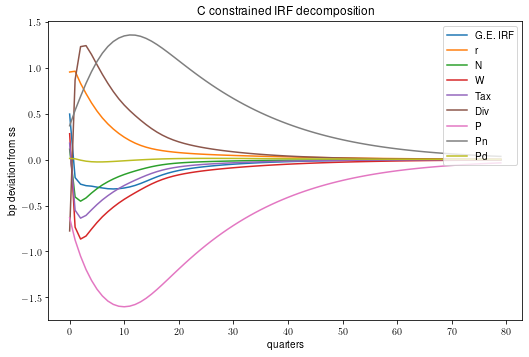

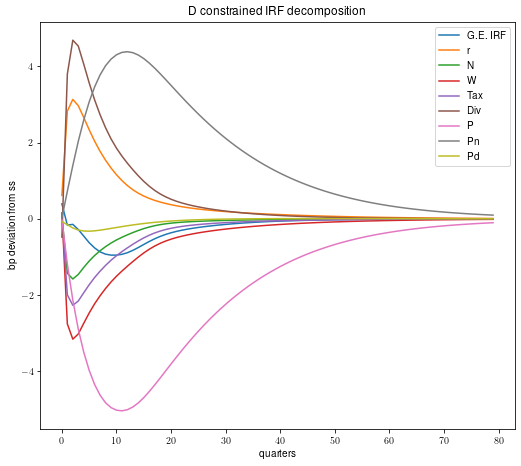

In [16]:
# a. collect P.E. IRFs for CONSTRAINED decomposition
dC_K = 10000*(G['C_K']['rstar'] @ drstar)
dD_K = 10000*(G['D_K']['rstar'] @ drstar)

dD_K_decomp = {}
dD_K_decomp['r'] = curlyJs[8]['D_K']['r'] @ dr
dD_K_decomp['N'] = curlyJs[8]['D_K']['N'] @ dN
dD_K_decomp['W'] = curlyJs[8]['D_K']['W'] @ dW
dD_K_decomp['Tax'] = curlyJs[8]['D_K']['Tax'] @ dTax
dD_K_decomp['Div'] = curlyJs[8]['D_K']['Div'] @ dDiv
dD_K_decomp['P'] = curlyJs[8]['D_K']['P'] @ dP
dD_K_decomp['Pn'] = curlyJs[8]['D_K']['P_n'] @ dP_n
dD_K_decomp['Pd'] = curlyJs[8]['D_K']['P_d'] @ dP_d

dC_K_decomp = {}
dC_K_decomp['r'] = curlyJs[8]['C_K']['r'] @ dr
dC_K_decomp['N'] = curlyJs[8]['C_K']['N'] @ dN
dC_K_decomp['W'] = curlyJs[8]['C_K']['W'] @ dW
dC_K_decomp['Tax'] = curlyJs[8]['C_K']['Tax'] @ dTax
dC_K_decomp['Div'] = curlyJs[8]['C_K']['Div'] @ dDiv
dC_K_decomp['P'] = curlyJs[8]['C_K']['P'] @ dP
dC_K_decomp['Pn'] = curlyJs[8]['C_K']['P_n'] @ dP_n
dC_K_decomp['Pd'] = curlyJs[8]['C_K']['P_d'] @ dP_d

# b. plots
# i. non-durable consumption decomposition
fig5, ax18 = plt.subplots()
ax18.plot(dC_K[:80],label="G.E. IRF")
for key in dC_K_decomp:
    current_label = key
    ax18.plot(dC_K_decomp[key][:80],label=current_label)
ax18.legend(loc="upper right")
ax18.set_ylabel('bp deviation from ss')
ax18.set_xlabel('quarters')
ax18.title.set_text('C constrained IRF decomposition')
fig5.set_size_inches(8.5, 5.5)


# ii. durable consumption decomposition
fig6, ax19 = plt.subplots()
ax19.plot(dD_K[:80],label="G.E. IRF")
for key in dD_K_decomp:
    current_label = key
    ax19.plot(dD_K_decomp[key][:80],label=current_label)
ax19.legend(loc="upper right")
ax19.set_ylabel('bp deviation from ss')
ax19.set_xlabel('quarters')
ax19.title.set_text('D constrained IRF decomposition')
fig6.set_size_inches(8.5, 7.5)

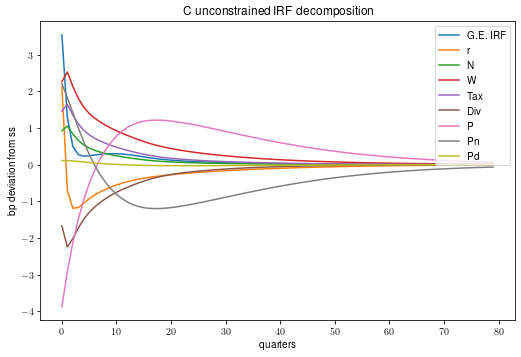

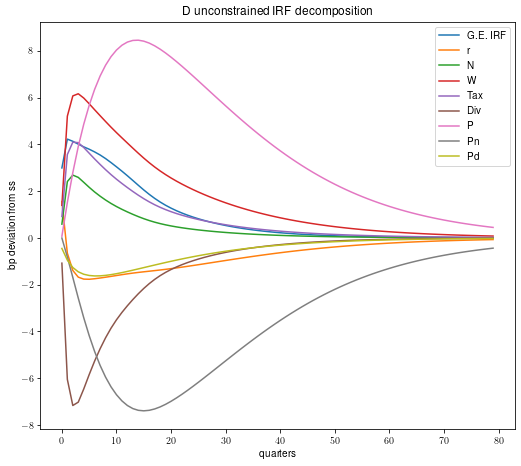

In [17]:
# a. collect P.E. IRFs for UNCONSTRAINED decomposition
dC_U = 10000*(G['C_U']['rstar'] @ drstar)
dD_U = 10000*(G['D_U']['rstar'] @ drstar)

dD_U_decomp = {}
dD_U_decomp['r'] = curlyJs[8]['D_U']['r'] @ dr
dD_U_decomp['N'] = curlyJs[8]['D_U']['N'] @ dN
dD_U_decomp['W'] = curlyJs[8]['D_U']['W'] @ dW
dD_U_decomp['Tax'] = curlyJs[8]['D_U']['Tax'] @ dTax
dD_U_decomp['Div'] = curlyJs[8]['D_U']['Div'] @ dDiv
dD_U_decomp['P'] = curlyJs[8]['D_U']['P'] @ dP
dD_U_decomp['Pn'] = curlyJs[8]['D_U']['P_n'] @ dP_n
dD_U_decomp['Pd'] = curlyJs[8]['D_U']['P_d'] @ dP_d

dC_U_decomp = {}
dC_U_decomp['r'] = curlyJs[8]['C_U']['r'] @ dr
dC_U_decomp['N'] = curlyJs[8]['C_U']['N'] @ dN
dC_U_decomp['W'] = curlyJs[8]['C_U']['W'] @ dW
dC_U_decomp['Tax'] = curlyJs[8]['C_U']['Tax'] @ dTax
dC_U_decomp['Div'] = curlyJs[8]['C_U']['Div'] @ dDiv
dC_U_decomp['P'] = curlyJs[8]['C_U']['P'] @ dP
dC_U_decomp['Pn'] = curlyJs[8]['C_U']['P_n'] @ dP_n
dC_U_decomp['Pd'] = curlyJs[8]['C_U']['P_d'] @ dP_d

# b. plots
# i. non-durable consumption decomposition
fig7, ax20 = plt.subplots()
ax20.plot(dC_U[:80],label="G.E. IRF")
for key in dC_U_decomp:
    current_label = key
    ax20.plot(dC_U_decomp[key][:80],label=current_label)
ax20.legend(loc="upper right")
ax20.set_ylabel('bp deviation from ss')
ax20.set_xlabel('quarters')
ax20.title.set_text('C unconstrained IRF decomposition')
fig7.set_size_inches(8.5, 5.5)


# ii. durable consumption decomposition
fig8, ax21 = plt.subplots()
ax21.plot(dD_U[:80],label="G.E. IRF")
for key in dD_U_decomp:
    current_label = key
    ax21.plot(dD_U_decomp[key][:80],label=current_label)
ax21.legend(loc="upper right")
ax21.set_ylabel('bp deviation from ss')
ax21.set_xlabel('quarters')
ax21.title.set_text('D unconstrained IRF decomposition')
fig8.set_size_inches(8.5, 7.5)